In [1]:
using Pkg
Pkg.add("Interpolations")
Pkg.add("Optim")

   Resolving package versions...
  No Changes to `C:\Users\bayle\Documents\Coding\Julia\Project.toml`
  No Changes to `C:\Users\bayle\Documents\Coding\Julia\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\bayle\Documents\Coding\Julia\Project.toml`
  No Changes to `C:\Users\bayle\Documents\Coding\Julia\Manifest.toml`


In [2]:
using Pkg
Pkg.add("PyPlot")
Pkg.add("LaTeXStrings")

   Resolving package versions...
  No Changes to `C:\Users\bayle\Documents\Coding\Julia\Project.toml`
  No Changes to `C:\Users\bayle\Documents\Coding\Julia\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\bayle\Documents\Coding\Julia\Project.toml`
  No Changes to `C:\Users\bayle\Documents\Coding\Julia\Manifest.toml`


In [3]:
using Interpolations, Optim

In [4]:
"""
A function that provides linear interpolation with constant extrapolation
outside the bounds.

    x : a linear grid of interpolation points
    fx : the values of the function on the grid points

"""
function lin_interp(x, fx)
    return linear_interpolation(x, fx,
    extrapolation_bc = Interpolations.Flat())
    
end

lin_interp

In [5]:
"""
Create an instance of the model, stored as a namedtuple.

"""
function create_opt_savings_model(; β=0.9, #Discount factor
                                    γ=2.0, #CRRA utility parameter
                                    R=1.2, #Gross rate of return
                                    w_size=200, #Grid size for wealth
                                    w_max=10) #maximum wealth
    w_grid = LinRange(1e-8, w_max, w_size) #Create the wealth grid
    u(c)=c^(1-γ)/(1-γ)
    v_init = u.(w_grid) #creating a vector of values for each point in the wealth grid
    return (; β, u, R, w_grid, v_init)
end


create_opt_savings_model

In [6]:
"""
The Bellman operator

    (Tv)(w) = min_{0 ≤ c ≤ w} { u(c) + β v(R(w - c))} Should be max and not min?

"""
function T(v, model)
    (; β, u, R, w_grid) = model #let this define our model

    v_new = similar(v) #create a new vector v_new of exactly the same type as v
    v = lin_interp(w_grid, v)  

    for (i, w) in enumerate(w_grid)
        result = maximize(c -> u(c) + β * v(R * (w-c)), 0.0, w) #choose the value of c which maximises the statement for each point in the wealth grid
        v_new[i]=Optim.maximum(result) 
    end

    return v_new
end


T

In [7]:
" Get a v-greedy policy "
function get_greedy(v, model)
    (; β, u, R, w_grid) = model
    σ = similar(v) #again, create a new vector the same as v. This will be our policy function
    v = lin_interp(w_grid, v)

    for (i,w) in enumerate(w_grid)
        result = maximize(c -> u(c) + β * v(R * (w-c)), 0.0, w)
        σ[i]=Optim.maximizer(result) #Notice the difference to the above. The policy function selects which value of c was the maximiser.
        
    end

    return σ
end

get_greedy

In [8]:
" Value Function Iteration"
function vfi(model;
                tolerance=1e-6,
                max_iter=10_000,
                print_step=100)
    
    k = 0
    error = tolerance + 1 #initial error, we just need this so we can start the loop
    v=model.v_init 

    while (error > tolerance) & (k <= max_iter) 
        v_new = T(v, model)
        error = maximum(abs.(v_new - v)) #supnorm. Error is the maximum pairwise distance
        if k % print_step == 0
            println("Completed iteration $k with error $error.")
        end
        v = v_new
        k += 1
    end

    if error <= tolerance
        println("Terminated successfully in $k iterations")
    else
        println("Warning: hit iteration bound.")    
    end

    σ= get_greedy(v, model) #Given wealth w today, what value of consumption do I choose?
    return σ, v
    
end

vfi

In [9]:
"""
The policy operator

    (T_σ v)(w) =  u(σ(w)) + β v[R(w - σ(w))]

"""
function T_σ(v, σ, model)
    (; β, u, R, w_grid) = model
    # Add your code here
    v_new= similar(v)
    v=lin_interp(w_grid,v)

    for (i, w) in enumerate(w_grid)
        c=σ[i]
        v_new[i]= u(c)+β*v(R*(w-c))
    end

    return v_new
    

end

T_σ

In [10]:
"Approximate lifetime value of policy σ." #Old code. John's code had a slightly different version; look below.
function get_value(v_init, σ, m, model)
    v = v_init
    k=0
    while k<m
        v = T_σ(v, σ, model)
        k+=1
    end
    return v
    # Compute and return T_σ^m v_init
    
end

get_value

In [11]:
"Approximate lifetime value of policy σ."
function get_value(v_init, σ, m, model)
    v = v_init
    for i in 1:m
        v = T_σ(v, σ, model)
    end
    return v
    # Compute and return T_σ^m v_init
end

get_value

In [12]:
"Optimistic policy iteration routine."
function opi(model; 
              tolerance=1e-6, 
              max_iter=1_000,
              m=20,
              print_step=10)
    v = model.v_init
    # Put your code here
    k = 0
    error = tolerance + 1

    while (error > tolerance) & (k<= max_iter)
        σ_new=get_greedy(v, model)
        v_new=get_value(v, σ_new, m, model)
        #v_new = T_σ(v, σ, model)
        error=maximum(abs.(v_new - v))
        if k % print_step == 0
            println("Completed iteration $k with error $error.")
        end
        v=v_new
        k+=1
    end

    if error <= tolerance
        println("Terminated successfully in $k iterations.")
    else
        println("Warning: hit iteration bound.")
    end

    σ= get_greedy(v, model)
    return σ, v
end

opi

In [13]:
using PyPlot
using LaTeXStrings
fontsize=12

12

In [14]:
model = create_opt_savings_model()
(; β, u, R, w_grid, v_init) = model;
println("Solving via VFI. \n\n")
@timev σ_star, v_star = vfi(model);

Solving via VFI. 


Completed iteration 0 with error 9.000000634421515e7.
Completed iteration 100 with error 2390.5260684490204.
Completed iteration 200 with error 0.06349575519561768.
Completed iteration 300 with error 1.6689300537109375e-6.
Terminated successfully in 306 iterations
  0.971230 seconds (1.68 M allocations: 114.843 MiB, 2.31% gc time, 94.74% compilation time)
elapsed time (ns):  971230400
gc time (ns):       22456100
bytes allocated:    120421655
pool allocs:        1679111
non-pool GC allocs: 1292
malloc() calls:     15
free() calls:       33
minor collections:  1
full collections:   0


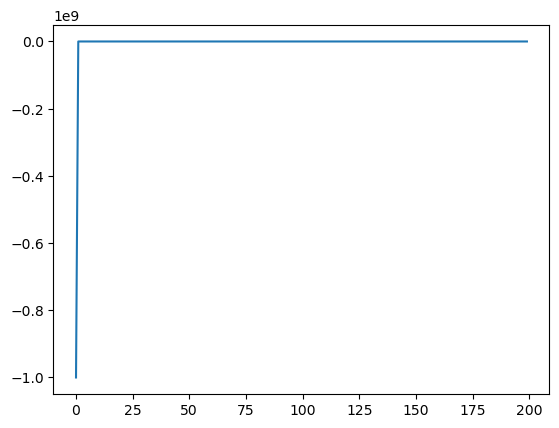

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000002342AFC0220>

In [15]:
plot(v_star)

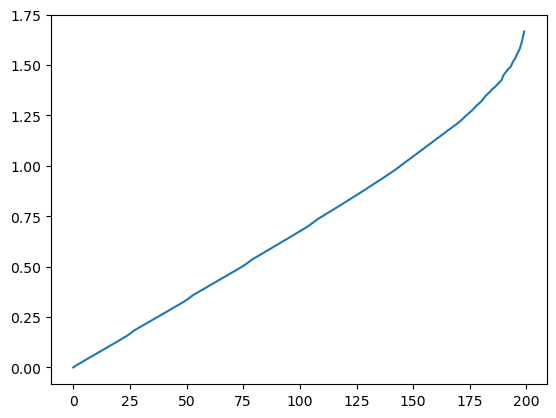

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000234284ACBB0>

In [16]:
plot(σ_star)

In [17]:
#model = create_opt_savings_model()
#(; β, u, R, w_grid, v_init) = model;
#σ=get_greedy(v_init, model)
#v=get_value(v_init, σ, 20, model)

In [18]:
println("\n\nSolving via HPI.\n\n")
@timev σ_star_opi, v_star_hpi = opi(model); #Run time for m=20 is 0.05s. Run time for m=2000 is 0.72s. Run time for m=20000 is 6.45s. Just change the value of m in OPI.



Solving via HPI.


Completed iteration 0 with error 7.905810665975548e8.
Completed iteration 10 with error 0.6048517163493692.
Terminated successfully in 18 iterations.
  0.134146 seconds (37.19 k allocations: 3.799 MiB, 92.52% compilation time)
elapsed time (ns):  134146400
gc time (ns):       0
bytes allocated:    3983220
pool allocs:        37135
non-pool GC allocs: 59
minor collections:  0
full collections:   0


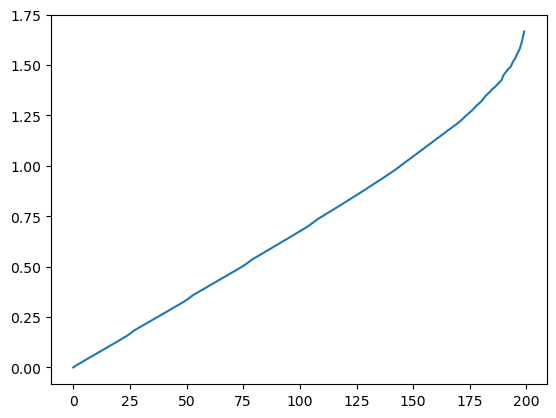

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000023428535A20>

In [19]:
plot(σ_star_opi)

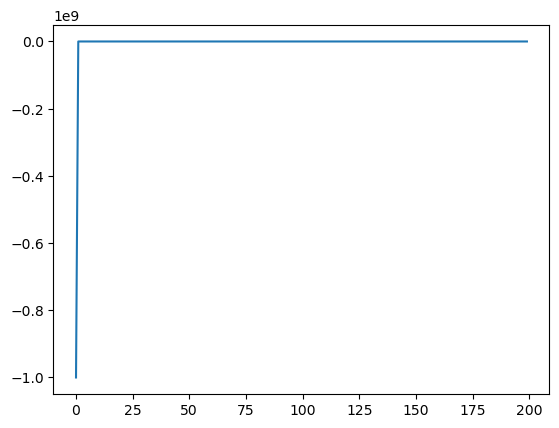

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000002342838A260>

In [20]:
plot(v_star_hpi)